In [15]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

import sigkernel as ksig_pde
import sigkernel_ as ksig_disc
import utils.data
from generators.synthetic_generators import *
from generators.ESN import ESNGenerator
from models.trainer_ESN_MMD import train_ESN_MMD
from sigkernel_.loss import compute_mmd_loss
from utils.analyse_training import plot_loss_from_run, inspect_run_and_mmd
from utils.kernel_helpers import median_heuristic_sigma

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype=torch.float64

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generator and ESN

In [3]:
# Generator and ESN details ----------------------
T = 200 # length of time series
N = 20  # number of samples
batch_size = N
N_target = N*3
d = 1   # dimension of time series
p = 2   # AR order
q = 0   # MA order
phi = [0.7, -0.2] # AR coefficients
theta = None # MA coefficients

h, m, d = 500, 20, 1 # ESN hyperparameters: reservoir size, input dimension, output dimension
A = 0.9 * torch.randn(h, h) / (h ** 0.5) # ESN reservoir weight matrix
C = torch.randn(h, m) / (m ** 0.5) # ESN input weight matrix
activation = "tanh"

# Define data generator and esn
target_generator = ARMA(T=T, p=p, q=q, phi=phi, theta=theta)
esn = ESNGenerator(A, C, out_dim=d, xi_scale=1.0, eta_scale=0.05, activation=activation)

In [4]:
# generate some sample paths
with torch.no_grad():
    X = target_generator.generate(N=N_target, noise=Noise("normal")).to(device=device, dtype=dtype)
    Z = esn(T=T, N=N).to(device=device, dtype=dtype)

print(f"Generated data shapes: X: {X.shape}, Z: {Z.shape}")

Generated data shapes: X: torch.Size([60, 200, 1]), Z: torch.Size([20, 200, 1])


In [5]:
dataset = TensorDataset(X)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,  # 20
    shuffle=True,           # mixes batches each pass
    drop_last=False,         # True to ensure strict batch size 20 
)


# Kernels

In [6]:
# Compute median heuristic sigma for RBF and sig_pde kernels
median_heuristic_sigma = median_heuristic_sigma(X,Z)
print(f"Median heuristic sigma: {median_heuristic_sigma:.6f}")

Median heuristic sigma: 26.136843


In [7]:
# Define the discretized signature kernel
static_kernel_type    = 'rbf' # type of static kernel to use - rbf, rbfmix, rq, rqmix, rqlinear for
n_levels              = 10 # number of levels in the truncated signature kernel
disc_sig_kernel_sigma = 1e-3 # bandwidth parameter for the static kernel

kwargs_disc_sig = {
    'static_kernel_type': static_kernel_type,
    'n_levels': n_levels,
    'kernel_sigma': disc_sig_kernel_sigma,
}

sig_disc_kernel = ksig_disc.kernels.get_discretized_signature_kernel(**kwargs_disc_sig)

#---------------------------------
# Define the pde signature kernel
# pde_sig_sigma = 1e1 # bandwidth parameter for the static kernel
pde_sig_sigma = median_heuristic_sigma # bandwidth parameter for the static kernel
static_kernel = ksig_pde.RBFKernel(sigma=pde_sig_sigma) # define static kernel

# Initialize the corresponding signature kernel
sig_pde_kernel = ksig_pde.SigKernel(static_kernel, dyadic_order=0)

#---------------------------------
# Define static kernel
static_sigma = median_heuristic_sigma # bandwidth parameter for the static kernel
rbf_kernel = ksig_disc.kernels.RBFKernel(sigma=static_sigma)

### Choose which kernel

In [8]:
# choose one:
# kernel = sig_disc_kernel      # discretized signature kernel
# kernel = sig_pde_kernel        # pde signature kernel
kernel = rbf_kernel           # static kernel

if "sig" in kernel.__class__.__name__.lower() or "volt" in kernel.__class__.__name__.lower():
    kernel_mode = "sequential"
else:
    kernel_mode = "static"

print(f"Using kernel: {kernel.__class__.__name__} with kernel mode: {kernel_mode}")
# initial mmd:
initial_mmd = compute_mmd_loss(kernel, X, Z) if kernel_mode == "sequential" else compute_mmd_loss(kernel, X.reshape(X.shape[0], -1), Z.reshape(Z.shape[0], -1))
print(f"Initial MMD: {initial_mmd:.6f}")

Using kernel: RBFKernel with kernel mode: static
Initial MMD: 0.010307


# Define parameters

In [ ]:
train_params = {
    "epochs": 1000,
    "batch_size": batch_size,
    "T": T,
    "d": d,
    "esn": esn,
    "dataloader": dataloader, # add the data loader
    "target_generator": None,
    "kernel": kernel,
    "kernel_mode": kernel_mode,
}

optim_params = {
    "lr": 1e-3,
    "lr_factor": 0.5,
    "plateau_patience": 75,
    "max_lr_drops": 3,
    "early_stopping_patience": 250,
    "min_lr": 1e-6,
}

loss_params = {
    "lead_lag": False,
    "lags": 1,
    "num_losses": 20,
}

io_params = {
    "out_dir": "./runs",
    "run_name": "esn_vs_ar2",
    "save_every": 50,
}

misc_params = {
    "dtype": torch.float64,
    "device": device,
}

kwargs = {
    **train_params,
    **optim_params,
    **loss_params,
    **io_params,
    **misc_params,
}

# Training

In [10]:
results = train_ESN_MMD(**kwargs)

train:  32%|███▏      | 322/1000 [00:15<00:31, 21.48it/s, avg_k=-.00199, drops=1, loss=-.00384, lr=0.0005] 

LR drop 1/3: lr -> 0.0005


train:  42%|████▏     | 415/1000 [00:20<00:24, 24.20it/s, avg_k=-.0006, drops=2, loss=-.00783, lr=0.00025]  

LR drop 2/3: lr -> 0.00025


train:  49%|████▉     | 489/1000 [00:24<00:25, 20.40it/s, avg_k=0.00078, drops=3, loss=0.000194, lr=0.000125] 

LR drop 3/3: lr -> 0.000125


train:  96%|█████████▌| 958/1000 [00:48<00:02, 19.73it/s, avg_k=-.000471, drops=3, loss=0.00603, lr=0.000125] 

Early stopping at epoch 958 (best avg_20 -0.00461424 at epoch 708, lr_drops_used=3)


# Visualize and analyse results

Note: LR history not stored per epoch yet. Overlay skipped.


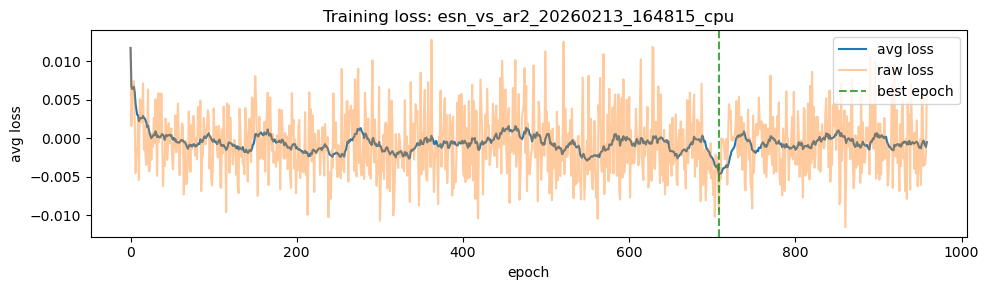

Final average loss: -0.0005
Final loss: 0.0060


In [11]:
losses = plot_loss_from_run(results, kwargs, overlay_raw=True, log_scale=False, overlay_lr = True, mark_best_and_drops=True)
print(f"Final average loss: {losses['avg_losses'][-1]:.4f}")
print(f"Final loss: {losses['losses'][-1]:.4f}")

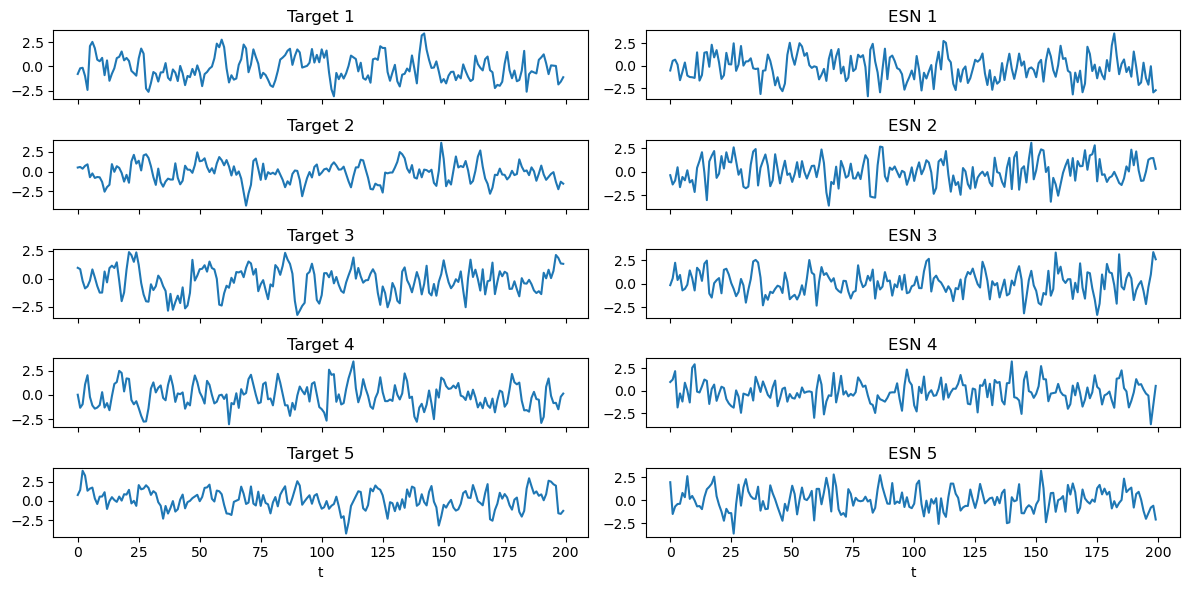

X shape: (20, 200, 1)
Z shape: (20, 200, 1)
kernel_mode: static
Xk shape: (20, 200)
Zk shape: (20, 200)
Xk features: 200 Zk features: 200
MMD: -0.002365557501623816


In [40]:
# is use generator can pick _T_mmd and _N_mmd for MMD computation
inspection = inspect_run_and_mmd(results, kwargs, n_examples=5, kernel_mmd = None, _T_mmd=None, _N_mmd=None)   